In [1]:
import re
import pandas as pd
import urllib.request
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from urllib.request import urlopen
from fa2 import ForceAtlas2
import re
import nltk
import io
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import community
from community import community_louvain
import ast
import urllib.request
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from urllib.request import urlopen
import json
from fa2 import ForceAtlas2
import powerlaw
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.colors as colors  
from PIL import Image
from collections import Counter

## Dataset

In [168]:
import requests

S = requests.Session()

URL = "https://witcher.fandom.com/api.php?"

PARAMS = {
    "action": "query",
    "format": "json",
    "list": "categorymembers",
    "cmtitle":"Category:Hearts_of_Stone_characters",
    "cmlimit":"500",
    "cmprop":"title",
    "continue":"||"
}

R = S.get(url=URL, params=PARAMS)
DATA = R.json()

PAGES = DATA["query"]

#for page in PAGES:
#    print(page["title"])

In [ ]:
idx_continue = DATA['continue']

In [113]:
PARAMS.update(DATA['continue'])

In [114]:
R = S.get(url=URL, params=PARAMS)
DATA = R.json()

PAGES_left = DATA["query"]

In [115]:
characters=PAGES["categorymembers"]+PAGES_left["categorymembers"]

In [171]:
characters_list=[x['title'] for x in characters if x['ns']==0]

In [173]:
del(characters_list[0])

In [137]:
def change_name(name):
    return name.replace(' ','_')

In [174]:
df = pd.DataFrame(list(map(change_name,characters_list)),columns=['Name'])
df =df.drop_duplicates(subset='Name',keep='first')
df.to_csv("Hearts_of_Stone_characters.csv",encoding='utf-8')

In [127]:
# Extract character list
baseurl = "https://witcher.fandom.com/api.php?"
action = "action=query"
title_1 = "titles=Norbert_von_Esteken"
#title_1 = "titles=%s"%characters_list[1]
content = "prop=revisions&rvprop=content&rvslots=*"
dataformat = "format=json"

query_1 = "%s%s&%s&%s&%s" %(baseurl, title_1, action, content, dataformat)

wikiresponse_1 = urlopen(query_1)
wikisource_1 = wikiresponse_1.read().decode('utf-8')
wikijson_1 = json.loads(wikisource_1)


In [165]:
df.to_csv("Blood_and_Wine_characters.csv",encoding='utf-8')

In [182]:
df1 = pd.read_csv('Blood_and_Wine_characters.csv')
df2 = pd.read_csv('Hearts_of_Stone_characters.csv')
df3 = pd.read_csv('The_Witcher_3_characters.csv')

In [185]:
df = pd.concat([df1, df2, df3])

In [189]:
df= df.reset_index(drop=True)
df.to_csv("characters.csv",encoding='utf-8')

In [2]:
G = nx.read_gpickle("graph.gpickle")

100%|██████████| 100/100 [00:01<00:00, 56.78it/s]

BarnesHut Approximation  took  0.20  seconds
Repulsion forces  took  1.50  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds


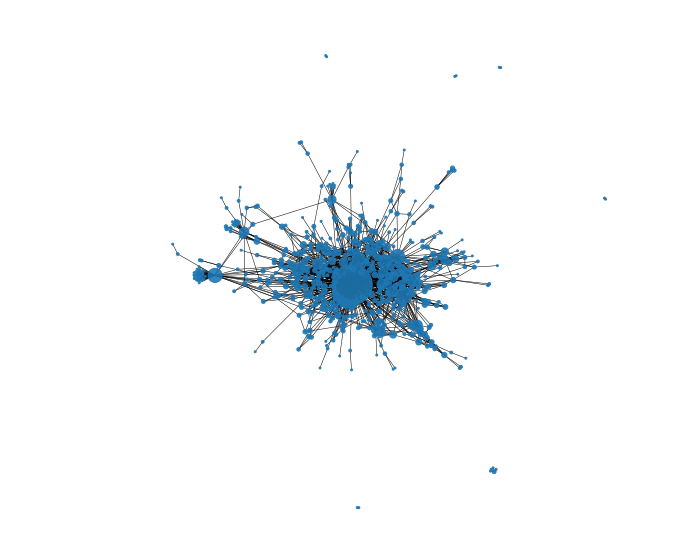

In [9]:
node_size = [i*4 for i in dict(G.degree).values()]
plt.figure(figsize=(12,10))

forceatlas2 = ForceAtlas2()
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=100)

nx.draw_networkx_nodes(G, positions, node_size=node_size, alpha=0.9)
nx.draw_networkx_edges(G, positions, alpha=1, width=0.5)

plt.axis('off')
plt.show()

100%|██████████| 200/200 [00:04<00:00, 43.54it/s]


BarnesHut Approximation  took  0.43  seconds
Repulsion forces  took  4.04  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.03  seconds


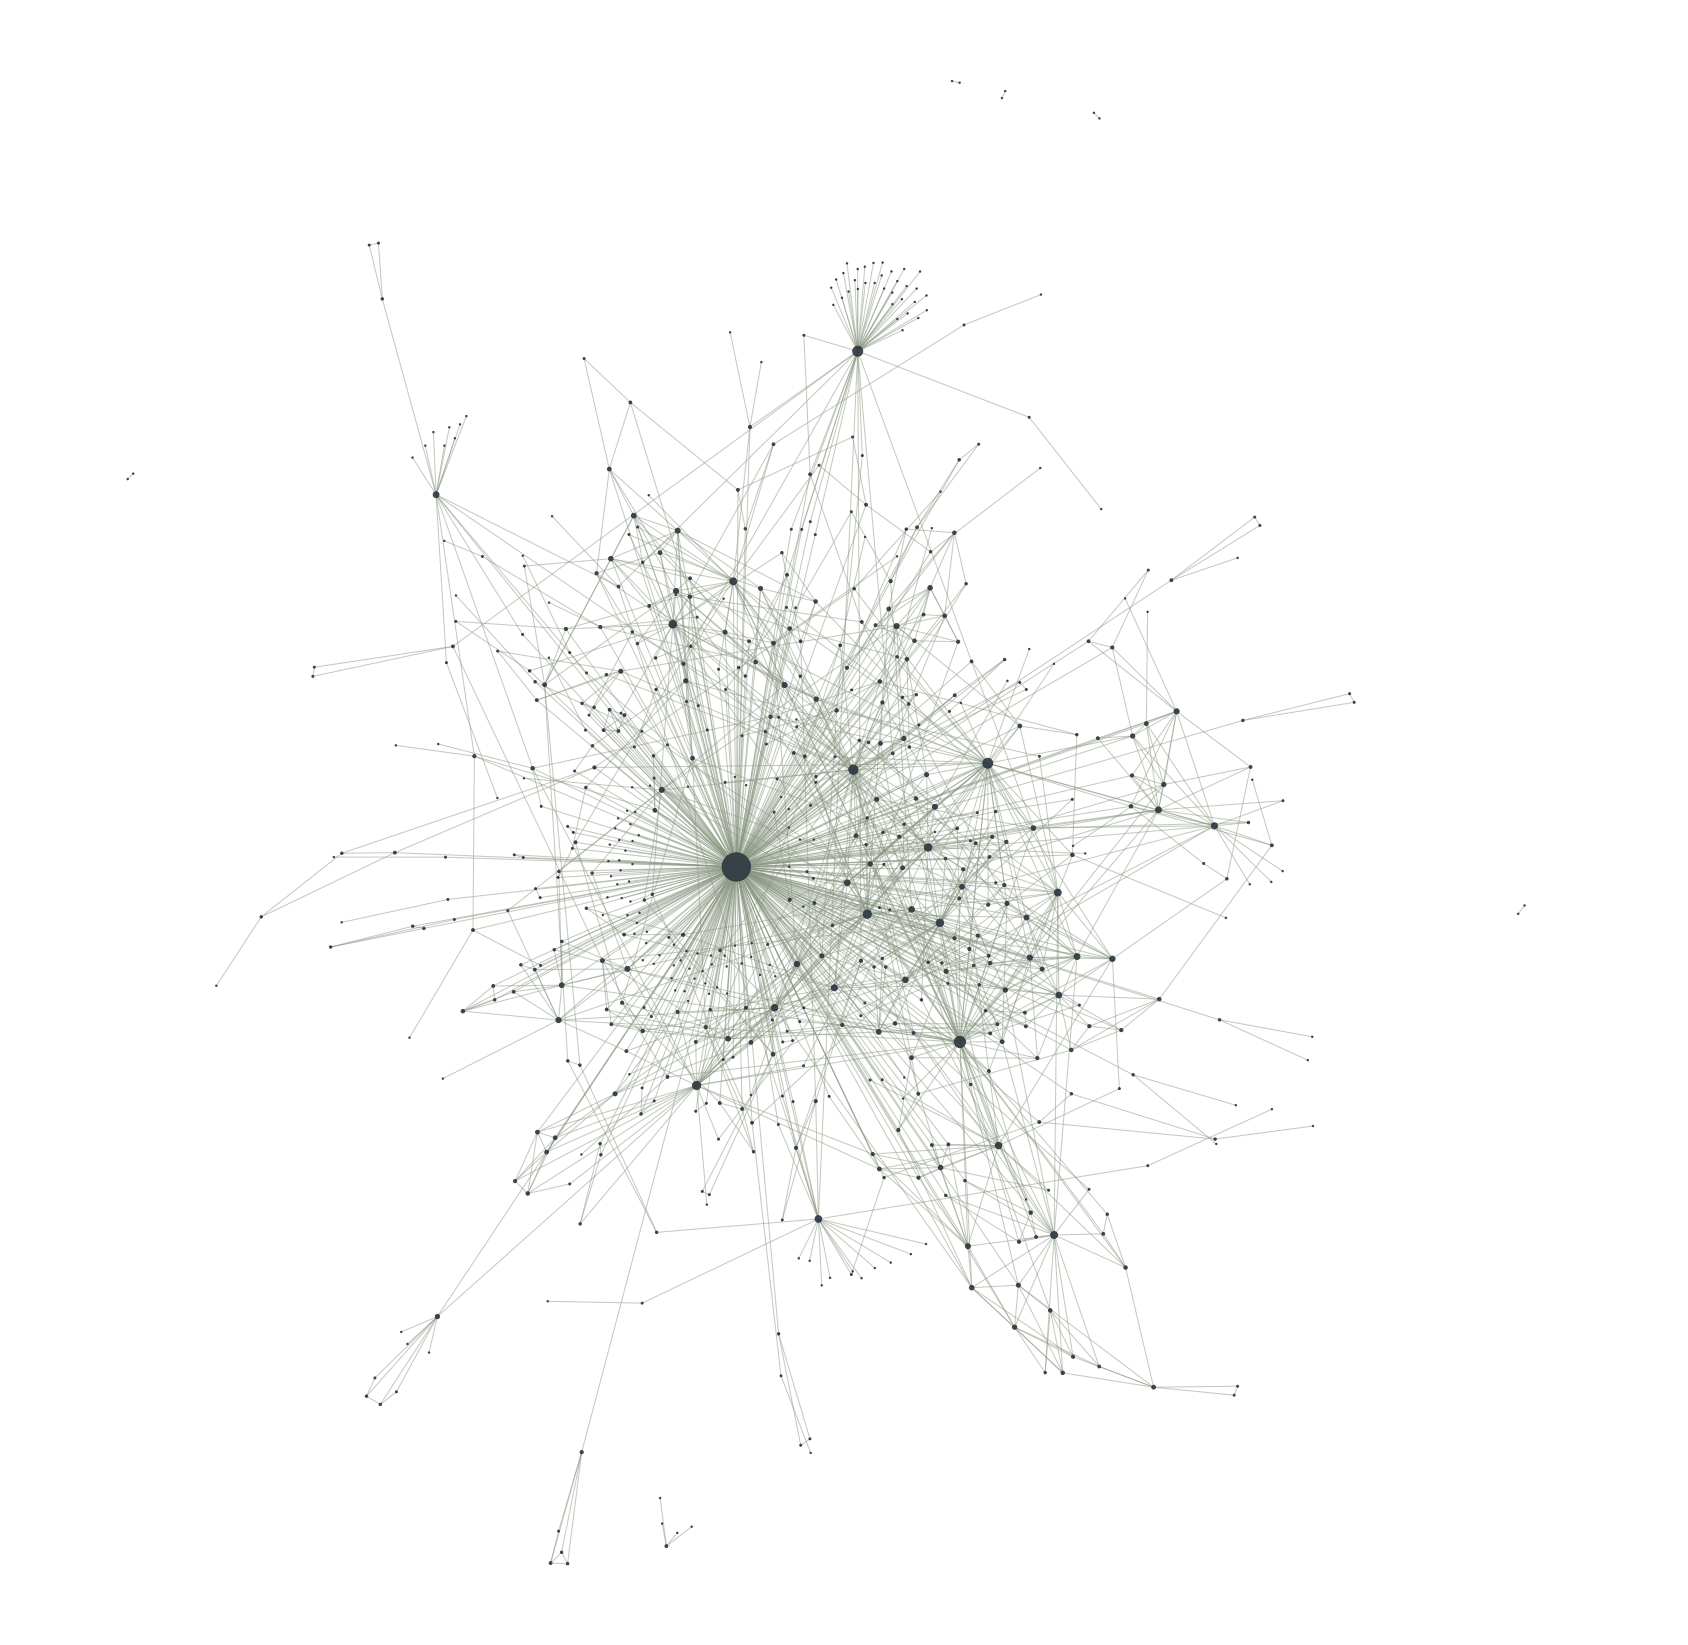

In [39]:
# Firstly, making an undirected version of the network so the plotting is better to work with
G_undirected = G.to_undirected()
      
# Making a list of sizes for each node, based on the node's degree
d = dict(G_undirected.degree)
sizes = [2*v for v in d.values()]

# Declaring Force Atlas 2 parameters
forceatlas2 = ForceAtlas2(outboundAttractionDistribution = False,
                          edgeWeightInfluence = 0.5,
                          jitterTolerance = 0.2,
                          barnesHutOptimize = True,
                          barnesHutTheta = 0.6,
                          scalingRatio = 2.0,
                          strongGravityMode = True,
                          gravity = 1.0)

# Making the graph
positions = forceatlas2.forceatlas2_networkx_layout(G_undirected, pos = None, iterations = 200)
nx.draw_networkx_nodes(G_undirected, positions, node_size = sizes, alpha = 0.9, node_color = '#2e3842')
nx.draw_networkx_edges(G_undirected, positions, edge_color = "#87947f", alpha = 0.5)
plt.rcParams["figure.figsize"] = [30,30]
plt.axis('off')
plt.show()

In [6]:
G.number_of_edges()

1514

In [7]:
G.number_of_nodes()

787

In [5]:
G = nx.read_gpickle("graph.gpickle")

In [14]:
df = pd.read_csv('./creatures.csv') 
creatures = df.Name.tolist()

In [33]:
page_path='./creature_description/'
for node in creatures:
    with open(page_path+node+'.txt', 'r',encoding='utf-8') as f:
        node_description = f.read()
    # Find Class
    pattern1 = "Class = \[\[(.*?)\]\]"
    list1=re.findall(pattern1, node_description)
    if list1:
        G.add_node(node, Class = list1[0])
    # Find Race
    pattern2 = "Race = \[\[(.*?)\]\]"
    list2=re.findall(pattern2, node_description)
    if list2:
        G.add_node(node, race = list2[0])
    # Find Profession
    pattern3 = "Profession = \[\[(.*?)\]\]"
    list3=re.findall(pattern3, node_description)
    if list3:
        G.add_node(node, Profession = list3[0])
    # Find Nationality
    pattern4 = "Nationality = \{\{(.*?)\}\}"
    list4=re.findall(pattern4, node_description)
    if list4:
        G.add_node(node, Nationality = list4[0])
    
    

In [36]:
nx.write_gpickle(G, "graph_with_attributes.gpickle")

In [41]:
node

'Wild_boar'

In [44]:
df.index[df['Name'] == node].tolist()

[786]

In [51]:
df1 = pd.concat([df, pd.DataFrame(columns=['Race']), pd.DataFrame(columns=['Profession']), pd.DataFrame(columns=['Nationality'])], sort=False)

In [82]:
for node in creatures:
    index = df.index[df['Name'] == node].tolist()
    with open(page_path+node+'.txt', 'r',encoding='utf-8') as f:
        node_description = f.read()
    # Find Class, for bestiary, it is included in Race
    pattern1 = "Class = \[\[(.*?)\]\]"
    list1=re.findall(pattern1, node_description)
    if list1:
        df1.loc[index, 'Race'] = list1[0]
    # Find Race
    pattern2 = "Race = \[\[(.*?)\]\]"
    list2=re.findall(pattern2, node_description)
    if list2:
        df1.loc[index, 'Race'] = list2[0]
    # Find Profession
    pattern3 = "Profession = \[\[(.*?)\]\]"
    list3=re.findall(pattern3, node_description)
    if list3:
        df1.loc[index, 'Profession'] = list3[0]
    # Find Nationality
    pattern4 = "Nationality = \{\{(.*?)\}\}"
    list4=re.findall(pattern4, node_description)
    if list4:
        df1.loc[index, 'Nationality'] = list4[0]
    # Find Occurence,for bestiary, it is included in Nationality
    pattern5 = "Occurrence = \[\[(.*?)\]\]"
    list5=re.findall(pattern5, node_description)
    if list5:
        df1.loc[index, 'Nationality'] = list5[0]

In [83]:
df1.to_csv("creatures_with_attributes.csv",encoding='utf-8')

In [84]:
df = df1

## 2 Statistics

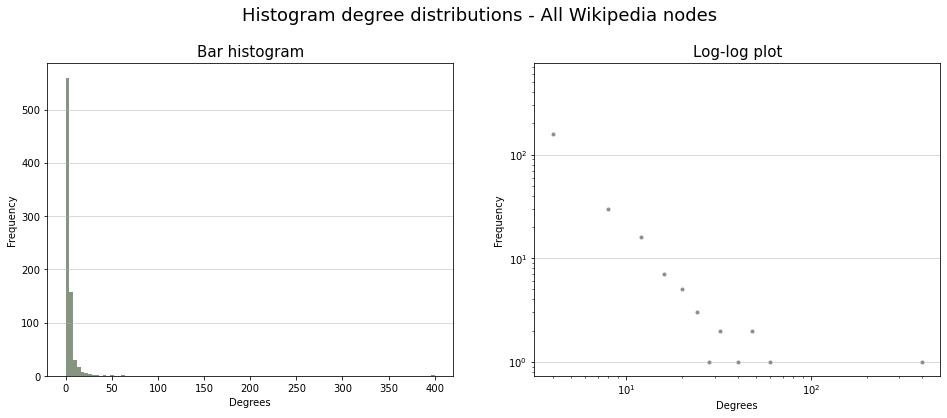

The minimum degree is 0
The maximum degree is 400


In [90]:
# Extracting the degree for each node
degrees = [G.degree(n) for n in G.nodes()]
degree_list = np.array(list(dict(G.degree).values())) # Extracting values from degree dictionary
max_degree = max(degree_list)
min_degree = min(degree_list)

# Using numpy.histogram to put the whole degree list into bins based on the created list above for the log-log plot
hist = np.histogram(degree_list, bins = 100)

# Constructing a figure of histogram degree distributions
figure1, axes1 = plt.subplots(nrows = 1, ncols = 2, figsize = (16,6))
figure1.suptitle('Histogram degree distributions - All Wikipedia nodes', fontsize = 18)

axes1[0].hist(degrees, bins = 100, color = '#87947f')
axes1[0].set_title('Bar histogram', fontsize = 15)
axes1[0].grid(axis = 'y', alpha = 0.6)
axes1[1].loglog(list(hist[1][:-1]), list(hist[0]), '.', color = '#87947f')
axes1[1].set_title('Log-log plot', fontsize = 15)
axes1[1].grid(axis = 'y', alpha = 0.6)

for i in range(0,2):
    axes1[i].set_xlabel('Degrees')
    axes1[i].set_ylabel('Frequency')

figure1.subplots_adjust(top = 0.85)
plt.show()

print(f'The minimum degree is {min_degree}')
print(f'The maximum degree is {max_degree}')

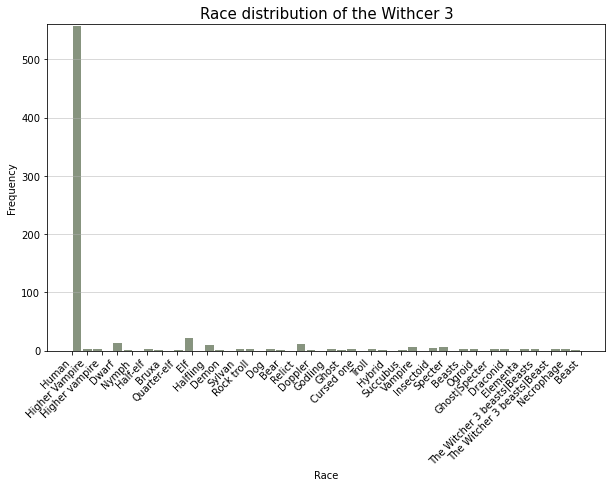

In [118]:
sns.reset_orig()

racelist = [i for i in newDf['Race']]

# Constructing a figure of the birth year distribution
plt.figure(figsize = (10,6))
n, bins, patches = plt.hist(x = racelist, bins = 50, color = '#87947f', rwidth = 0.85)
plt.title('Race distribution of the Withcer 3', fontsize = 15)
plt.grid(axis = 'y', alpha = 0.6)
plt.xlabel('Race')
plt.ylabel('Frequency')
maxfreq = n.max()
# Setting a clean upper y-axis limit
plt.xticks(rotation=45, ha='right')
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.show()


In [119]:
Counter(racelist)

Counter({'Human': 557,
         'Higher Vampire': 2,
         'Higher vampire': 2,
         'Dwarf': 13,
         'Nymph': 1,
         'Half-elf': 2,
         'Bruxa': 1,
         'Quarter-elf': 1,
         'Elf': 21,
         'Halfling': 9,
         'Demon': 1,
         'Sylvan': 2,
         'Rock troll': 3,
         'Dog': 2,
         'Bear': 1,
         'Relict': 11,
         'Doppler': 1,
         'Godling': 2,
         'Ghost': 1,
         'Cursed one': 3,
         'Troll': 2,
         'Hybrid': 1,
         'Succubus': 1,
         'Vampire': 7,
         'Insectoid': 5,
         'Specter': 6,
         'Beasts': 3,
         'Ogroid': 2,
         'Ghost|Specter': 2,
         'Draconid': 3,
         'Elementa': 2,
         'The Witcher 3 beasts|Beasts': 2,
         'The Witcher 3 beasts|Beast': 2,
         'Necrophage': 3,
         'Beast': 1})

In [116]:

Counter(nationlist)


Counter({'Toussaintois': 92,
         'Skelliger': 124,
         'Alban': 10,
         'Lyrian-Rivian': 1,
         'Nilfgaardian': 9,
         'Temerian': 109,
         'Crinfrider': 2,
         'Nazairi': 13,
         'Cintran': 2,
         'Kovirian': 5,
         'Redanian': 106,
         'Malleorean': 1,
         'Ofiri': 7,
         'Maechtian': 1,
         'Aedirnian': 3,
         'Metinnese': 3,
         'Attrean': 4,
         'Povissite': 1,
         'Mahakaman': 4,
         'Cidarian': 1,
         'redanian': 1,
         'Zerrikanian': 1,
         'Novigradian': 13,
         'Velen': 2,
         'Kaedwenian': 3,
         'Novigrad': 1,
         'Creydener': 1,
         'Toussaint': 25,
         'Blood Simple': 1,
         'Land of a Thousand Fables': 7,
         'Dragon Mountains': 1,
         'Dulcinea Windmill': 1,
         'Mont Crane Castle': 1,
         'Seidhe Llygad Amphitheater': 1,
         'Hen Gàidh': 1,
         'Tourney Grounds': 1,
         'Corvo Bianco': 1,
   

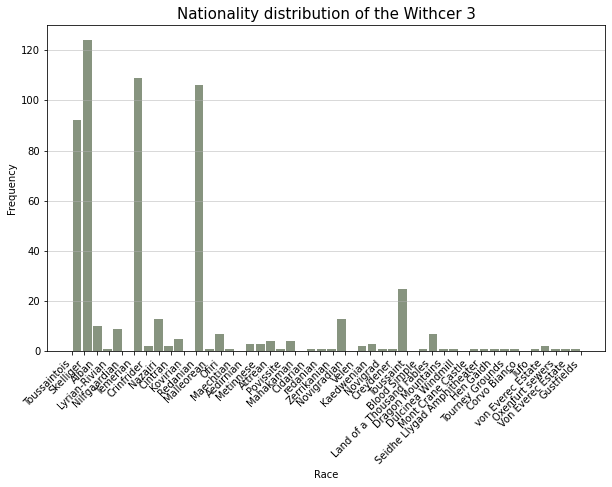

In [117]:
newDF_nation = df.dropna(subset=['Nationality'])
sns.reset_orig()

nationlist = [i for i in newDF_nation['Nationality']]

# Constructing a figure of the birth year distribution
plt.figure(figsize = (10,6))
n, bins, patches = plt.hist(x = nationlist, bins = 50, color = '#87947f', rwidth = 0.85)
plt.title('Nationality distribution of the Withcer 3', fontsize = 15)
plt.grid(axis = 'y', alpha = 0.6)
plt.xlabel('Race')
plt.ylabel('Frequency')
maxfreq = n.max()
# Setting a clean upper y-axis limit
plt.xticks(rotation=45, ha='right')
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.show()

## 3 Word Clouds

In [88]:
newDf = df.dropna(subset=['Race'])

In [89]:
# Based on Race
file_list_all = [i+'.txt' for i in creatures]
df['file_name'] = file_list_all
file_list = []
for i in creatures: 
    if df[df['Name']==i].Race.isnull().bool():
        pass
    else:
        file_list.append(i+'.txt')

newDf = df.dropna(subset=['Race'])
        
corpus_root = 'creature_description'
filelists = nltk.corpus.PlaintextCorpusReader(corpus_root, file_list)
Zelda_Text = nltk.Text(filelists.words())

races = newDf['Race'].unique()
race_texts = []  

for r in races:
    file_race = newDf[newDf['Race']==r].file_name
    r_corpus = nltk.corpus.PlaintextCorpusReader(corpus_root, file_race)
    r_Text = nltk.Text(r_corpus.words())
    race_texts.append(r_Text)

def compute_tf(words, doc):
    tf = [doc.count(i)/len(doc) for i in words]
    return tf

def compute_idf(words, docs):
    idf_m = np.empty(shape=(len(docs),len(words)))
    
    for i,d in enumerate(docs):
        if_exist = [1 if i in d else 0 for i in words]
        idf_m[i,:] = if_exist
    
    idf =  np.log(len(docs) / np.sum(idf_m, axis=0))
    
    return idf
    
race_tf = []; common_words = []  

for i, r in enumerate(race_texts):
    fdist = nltk.FreqDist(r)
    most_5 = fdist.most_common(5); words = [i[0] for i in most_5]
    tf = compute_tf(words, r)
    words_tf = list(zip(words, tf))
    race_tf.append(words_tf)
    common_words.append(words)


race_idf = []
for i in common_words: #words = [i[0] for i in most_5]
    idf = compute_idf(i, race_texts)
    race_idf.append(idf)

tf_idfs = []
for r in race_texts:
    words = set(r)
    tf = compute_tf(words, r)
    idf = compute_idf(words, race_texts)
    tf_idf = tf * idf
    tf_idfs.append(tf_idf)

for i, t in enumerate(tf_idfs):
    index = np.argsort(t)[-5:]   #sorted(range(len(t)), key=lambda x: t[x])[-5:]
    content = list(set(race_texts[i]))
    words = [content[n] for n in index]

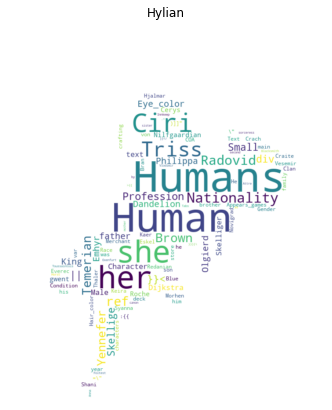

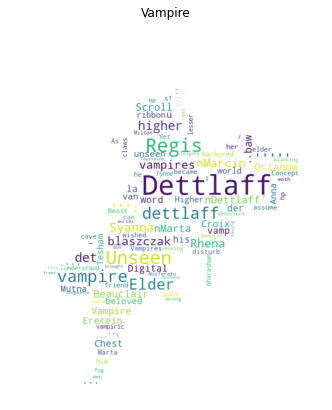

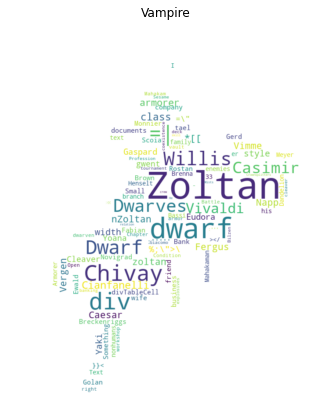

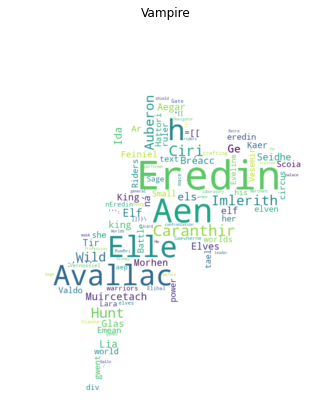

In [127]:
# Human
plt.figure(figsize=(7, 7))
color_mask_Hylian= np.array(Image.open('Hylia.png'))
word_tfidf_0 = pd.Series(tf_idfs[0], index=list(set(race_texts[0])))
wc_0 = WordCloud(mask=color_mask_Hylian,background_color="white", max_words=100, collocations = False).generate_from_frequencies(word_tfidf_0)
plt.imshow(wc_0, interpolation='bilinear')
plt.axis("off")
plt.title("Hylian")
plt.show()

# Vampire
plt.figure(figsize=(7, 7))
color_mask_Hylian= np.array(Image.open('Hylia.png'))
word_tfidf_0 = pd.Series(tf_idfs[1], index=list(set(race_texts[1])))
wc_0 = WordCloud(mask=color_mask_Hylian,background_color="white", max_words=100, collocations = False).generate_from_frequencies(word_tfidf_0)
plt.imshow(wc_0, interpolation='bilinear')
plt.axis("off")
plt.title("Vampire")
plt.show()

# Dwarf
plt.figure(figsize=(7, 7))
color_mask_Hylian= np.array(Image.open('Hylia.png'))
word_tfidf_0 = pd.Series(tf_idfs[3], index=list(set(race_texts[3])))
wc_0 = WordCloud(mask=color_mask_Hylian,background_color="white", max_words=100, collocations = False).generate_from_frequencies(word_tfidf_0)
plt.imshow(wc_0, interpolation='bilinear')
plt.axis("off")
plt.title("Vampire")
plt.show()

# Elf
plt.figure(figsize=(7, 7))
color_mask_Hylian= np.array(Image.open('Hylia.png'))
word_tfidf_0 = pd.Series(tf_idfs[8], index=list(set(race_texts[8])))
wc_0 = WordCloud(mask=color_mask_Hylian,background_color="white", max_words=100, collocations = False).generate_from_frequencies(word_tfidf_0)
plt.imshow(wc_0, interpolation='bilinear')
plt.axis("off")
plt.title("Vampire")
plt.show()

In [63]:
df.head()

,Unnamed: 0,Name,Link,Race,Profession,Nationality,file_name
0,0.0,Adrien_de_Rouleau,"['Human', 'Bard', 'Toussaint', 'bard', 'Beaucl...",Human,Bard,Toussaintois,Adrien_de_Rouleau.txt
1,1.0,Agnetha_Skold,"['Human', 'Skelliger', 'gwent', 'the_Pheasantr...",Human,NaN,Skelliger,Agnetha_Skold.txt
2,2.0,Ambassador_von_Hinn,"['Human', 'Ambassador', 'Toussaint', 'Ambassad...",Human,Ambassador,Alban,Ambassador_von_Hinn.txt
3,3.0,Andrée_de_Bourbeau,"['Human', 'Jean-Christophe_de_Bourbeau', 'Jean...",Human,NaN,Toussaintois,Andrée_de_Bourbeau.txt
4,4.0,Anna_Henrietta,"['Duchess', 'Duchess', 'Toussaint', 'Human', '...",Human,NaN,Toussaintois,Anna_Henrietta.txt


## 4 Sentiment analysis


In [128]:
Gs = sorted(nx.connected_components(G), key=len, reverse=True)
Gcc = G.subgraph(Gs[0])

partition = community_louvain.best_partition(Gcc)
communities = list(set(partition.values())) 

In [130]:
len(communities)

22

In [131]:
community_names = []
for c in communities:
    sub_nodes = [k for k,v in partition.items() if v == c]
    sub_G = G.subgraph(sub_nodes)
    top_3 = [k for k, v in sorted(dict(sub_G.degree()).items(), key=lambda item: item[1], reverse=True)[:3]]
    name = ', '.join(top_3)
    community_names.append(name)

In [132]:
wnl = nltk.WordNetLemmatizer()
def get_tokens(string):
    tokens_tmp = WordPunctTokenizer().tokenize(string)
    words = [t.lower() for t in tokens_tmp if t.isalpha()]#(t.isalpha() and t.lower() not in stopwords.words('english'))
    tokens = [wnl.lemmatize(t) for t in words]
    return tokens

def calculate_sentiment(tokens):
    h_avgs = []
    for i, t in enumerate(tokens):
        if t in list(labmit_df['word']):
            idx = labmit_df[(labmit_df.word==t)].index[0]
            h_avg = labmit_df.loc[idx, 'happiness_average']
            h_avgs.append(h_avg)
    return np.mean(h_avgs)